In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers
import tensorflow as tf
%matplotlib inline

In [2]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [3]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 15000
EMBEDDING_DIM = 200 #100
VALIDATION_SPLIT = 0.2
LOAD_MODEL = True # True
EVALUATION_MODE = False
RUNS = 1

In [4]:
# reading data
import tensorflow_datasets as tfds

import sys

sys.path.append(r"myutils")

from myutils import clean_doc,clean_doc_HAN


import os

In [5]:
#Load train dataset
DATASET = "imdb_reviews"   #   'yelp_polarity_reviews'
train = tfds.as_numpy(tfds.load(DATASET, data_dir=f"{DATASET}", split="train", batch_size=-1))
reviews = []
for x in train["text"]:
    #print(clean_doc_HAN(x.decode()))
    reviews.append(clean_doc_HAN(x.decode()))

X_train, y_train = [clean_doc(x.decode()) for x in train["text"]], train["label"]

# Load test dataset
test = tfds.as_numpy(tfds.load(DATASET, data_dir=f"{DATASET}", split="test", batch_size=-1))
X_test, y_test = [clean_doc(x.decode()) for x in test["text"]], test["label"]

print(f"Train samples: {len(X_train)}")
print(f"Test samples:  {len(X_test)}")

Train samples: 25000
Test samples:  25000


In [6]:
if LOAD_MODEL:
    with open('model/tokenizer_han.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
else:
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(X_train)

data1 = np.zeros((len(X_train), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    #print(sentences)
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if word in tokenizer.word_index.keys():
                    if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                        data1[i,j,k] = tokenizer.word_index[word]
                        k=k+1


In [7]:
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

No. of 121361 unique tokens.


In [8]:
labels1 = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data1.shape)
print('Shape of label tensor:', labels1.shape)

Shape of data tensor: (25000, 15, 100)
Shape of label tensor: (25000, 2)


In [9]:
from myutils import create_glove_embeddings_HAN

embeddings_index = create_glove_embeddings_HAN(EMBEDDING_DIM)

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=True)

Pretrained GloVe embedding is loading...
Found 400000 word vectors in GloVe embedding



In [10]:
if LOAD_MODEL:
    from keras.models import load_model

    model=load_model('model_han_.h5')
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.SGD(),
              metrics=['acc'])
    model.summary()
else:
    sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sentence_input)
    l_lstm = Bidirectional(LSTM(50))(embedded_sequences)
    sentEncoder = Model(sentence_input, l_lstm)

    review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
    review_encoder = TimeDistributed(sentEncoder)(review_input)
    l_lstm_sent = Bidirectional(LSTM(50))(review_encoder)
    preds = Dense(2, activation='softmax')(l_lstm_sent)
    model = Model(review_input, preds)

    model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.SGD(),
              metrics=['acc'])

    print("Hierachical LSTM")
    model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 100)]         0         
                                                                 
 time_distributed (TimeDistr  (None, 15, 100)          24372800  
 ibuted)                                                         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 24,433,402
Trainable params: 24,433,402
Non-trainable params: 0
_________________________________________________________________


In [11]:
if not EVALUATION_MODE:

    cp=ModelCheckpoint('model_han_.h5',monitor='val_loss',verbose=1,save_best_only=True, mode="min")
    earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=2,
                          verbose=1)
    
    for i in range(RUNS):
        print(f"Running iteration {i+1}/{RUNS}")


        indices = np.arange(data1.shape[0])
        np.random.shuffle(indices)
        data = data1[indices]
        labels = labels1[indices]
        nb_validation_samples = int(VALIDATION_SPLIT * data1.shape[0])
        
        x_train = data[:-nb_validation_samples]
        y_train = labels[:-nb_validation_samples]
        x_val = data[-nb_validation_samples:]
        y_val = labels[-nb_validation_samples:]


        history=model.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=15, batch_size=50,callbacks=[cp, earlystop])

Running iteration 1/1
Epoch 1/13
400/400 [==============================] - ETA: 0s - loss: 0.4364 - acc: 0.7984
Epoch 1: val_loss improved from inf to 0.42089, saving model to model_han_.h5
400/400 [==============================] - 479s 1s/step - loss: 0.4364 - acc: 0.7984 - val_loss: 0.4209 - val_acc: 0.8130
Epoch 2/13
400/400 [==============================] - ETA: 0s - loss: 0.4194 - acc: 0.8090
Epoch 2: val_loss did not improve from 0.42089
400/400 [==============================] - 456s 1s/step - loss: 0.4194 - acc: 0.8090 - val_loss: 0.4365 - val_acc: 0.7978
Epoch 3/13
400/400 [==============================] - ETA: 0s - loss: 0.4122 - acc: 0.8124
Epoch 3: val_loss improved from 0.42089 to 0.38678, saving model to model_han_.h5
400/400 [==============================] - 397s 991ms/step - loss: 0.4122 - acc: 0.8124 - val_loss: 0.3868 - val_acc: 0.8300
Epoch 4/13
400/400 [==============================] - ETA: 0s - loss: 0.4064 - acc: 0.8164
Epoch 4: val_loss did not improve from

In [12]:
if not EVALUATION_MODE:
    with open('model/tokenizer_han.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("tokenizer has been saved.")

tokenizer has been saved.


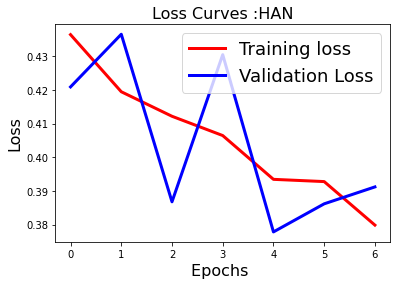

In [13]:
if not EVALUATION_MODE:
    fig1 = plt.figure()
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves :HAN',fontsize=16)
    fig1.savefig('loss_han.png')
    plt.show()

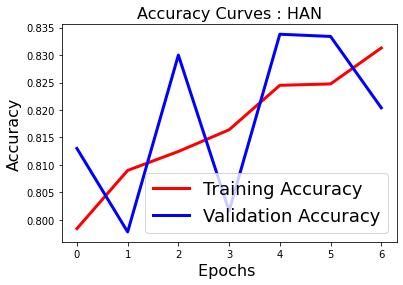

In [14]:
if not EVALUATION_MODE:
    fig2=plt.figure()
    plt.plot(history.history['acc'],'r',linewidth=3.0)
    plt.plot(history.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves : HAN',fontsize=16)
    fig2.savefig('accuracy_han.png')
    plt.show()

In [15]:
if not EVALUATION_MODE:
    from keras.utils.vis_utils import plot_model
    plot_model(model, to_file='han_model.png', show_shapes=True, show_layer_names=True)

In [16]:
if EVALUATION_MODE:
    from PIL import Image
    display(Image.open('han_model.png'))

In [17]:
from keras.models import load_model
# evaluation
with open('model/tokenizer_han.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
sequences_test = tokenizer.texts_to_sequences(X_test)

data_test = np.zeros((len(X_test), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    #print(sentences)
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if word in tokenizer.word_index.keys():
                    if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                        data_test[i,j,k] = tokenizer.word_index[word]
                        k=k+1

X_test_word_han=data_test
                        
test_loss = []
test_accs = []


han_ = load_model(f"model_han_.h5")
score = han_.evaluate(X_test_word_han, to_categorical(y_test), verbose=1)
test_loss.append(score[0])
test_accs.append(score[1])
    
print(f"\nLoss / accuracy on testset: {np.mean(test_loss)} loss / {np.mean(test_accs)} acc")
print(f"Standard deviation: (+-{np.std(test_loss)}) loss / (+-{np.std(test_accs)}) acc")


782/782 [==============================] - 110s 137ms/step - loss: 1.1742 - acc: 0.4988

Loss / accuracy on testset: 1.1741790771484375 loss / 0.49876001477241516 acc
Standard deviation: (+-0.0) loss / (+-0.0) acc
